In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Static Variables

In [15]:
line = "1"

### Extracting Data

In [16]:
df = pd.read_csv("bus_data/clean_data2/" + line + ".csv", low_memory=False, header=None)
df.columns = ["Timestamp", "LineID", "JourneyPatternID", "TimeFrame", 
              "VehicleJourneyID", "Lon", "Lat", "VehicleID", "StopID", 
              "AtStop", "HumanTime", "Day", "Hour", "JourneyGroup", "Runtime"]

#convert StopID to string

df['StopID'] = df['StopID'].astype('str')


df.shape

(156755, 15)

In [17]:
schedule = pd.read_csv("bus_data/dublinbus_scheduledData2013csv.csv", low_memory=False, encoding="ISO-8859-1")


In [18]:
schedule = schedule.dropna()

### Exploring schedule

In [19]:
schedule.tail(1000)

,trip_id,arrival_time,departure_time,stop_id,Name without locality,Name,Lat,Long,stop_sequence,stop_headsign,shape_dist_traveled
921293,9986.2901.0-39-b12-1.242.I,23:39:26,23:39:26,8220DB001702,Nephin Road,Navan Road,53.365621,-6.310213,54,Baggot St,19629.936770
921294,9986.2901.0-39-b12-1.242.I,23:40:00,23:40:00,8220DB001703,Nephin Road,Navan Road,53.364717,-6.307334,55,Baggot St,19847.305120
921295,9986.2901.0-39-b12-1.242.I,23:41:00,23:41:00,8220DB001905,Hampton Green,Navan Road,53.363281,-6.303003,56,Baggot St,20175.174550
921296,9986.2901.0-39-b12-1.242.I,23:42:00,23:42:00,8220DB001906,Dunard,Old Cabra Rd,53.361201,-6.297061,57,Baggot St,20642.466700
921297,9986.2901.0-39-b12-1.242.I,23:43:00,23:43:00,8220DB001907,Glenbeigh Road,Old Cabra Rd,53.359905,-6.293807,58,Baggot St,20902.098670
921298,9986.2901.0-39-b12-1.242.I,23:43:27,23:43:27,8220DB001908,Cabra Drive,Old Cabra Rd,53.358682,-6.291241,59,Baggot St,21121.340750
921299,9986.2901.0-39-b12-1.242.I,23:44:00,23:44:00,8220DB001909,Drumalee,Prussia Street,53.356890,-6.288504,60,Baggot St,21393.334270
921300,9986.2901.0-39-b12-1.242.I,23:45:00,23:45:00,8220DB001713,Stanhope Street Convent,Manor Street,53.351908,-6.283310,61,Baggot St,22054.530400
921301,9986.2901.0-39-b12-1.242.I,23:45:39,23:45:39,8220DB001714,Brunswick Street,Stoneybatter,53.350638,-6.281874,62,Baggot St,22227.051460
921302,9986.2901.0-39-b12-1.242.I,23:46:55,23:46:55,8220DB001715,Blackhall Street,Blackhall Place,53.347712,-6.282172,63,Baggot St,22550.645330


In [20]:
# Extracting StopID from stop_id

def get_stop(string):
    var = string[-4:]
    return var

schedule["StopID"] = schedule['stop_id'].apply(lambda x: get_stop(x))

In [21]:
# Extracting LineID from trip_id

schedule["LineID"] = schedule["trip_id"].str.extract('\-(.*?)\-')

/Users/danieljordan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()


In [22]:
# Convert StopIDs back to int
df['StopID'] = df['StopID'].astype('int64')
schedule['StopID'] = schedule['StopID'].astype('int64')

In [23]:
# Number of unique LineIDs 

lines = schedule["LineID"].unique()

print(lines)

['33A' '41C' '114' '39' '25A' '25X' '39A' '75' '41' '13' '747' '9' '76'
 '53' '151' '104' '27' '63' '44' '123' '11' '4' '16' '16C' '1' '61' '15'
 '236' '84' '185' '38' '70' '14' '38A' '14C' '40' '40B' '83' '38B' '83A'
 '18' '45A' '29A' '31' '31A' '32' '7' '7D' '150' '145' '184' '46A' '47'
 '140' '41A' '43' '42' '65B' '65' '41B' '33' '27B' '102' '33B' '17A' '25B'
 '122' '25' '17' '59' '67' '120' '238' '270' '27A' '56A' '77A' '37' '26'
 '66' '66A' '220' '130' '40D' '15B' '15A' '54A' '49' '79A' '79' '68' '69'
 '116' '161' '41X' '239' '68A' '69X' '66X' '51D' '8' '7B' '33X' '66B' '67X'
 '76A' '27X' '44B' '84A' '51X' '46E' '31B' '111' '32X' '142' '84X' '118']


In [11]:
# Isolating line
# Examining how many stops are on each variation
# Saving this info in stops

schedule_line = schedule[schedule.LineID == line]

headsigns = schedule_line.stop_headsign.unique()

stops = {}

for sign in headsigns:
    stop_count = schedule_line[schedule_line.stop_headsign == sign].StopID.nunique()
    stop_list = schedule_line[schedule_line.stop_headsign == sign].StopID.unique()
    stops[sign] = [stop_count, stop_list]

In [12]:
# Getting max value for headsign
max_headsign = schedule_line['stop_headsign'].value_counts().idxmax()
schedule_line = schedule_line[schedule_line.stop_headsign == max_headsign]

### Exploring line 15

In [13]:
# # Isolating variations - getting variation with most stops

# df_0001 = df[df.JourneyPatternID == 1]
# df_1001 = df[df.JourneyPatternID == 1001]
# df_0002 = df[df.JourneyPatternID == 2]
# df_1002 = df[df.JourneyPatternID == 1002]

max_pattern = df['JourneyPatternID'].value_counts().idxmax()
df = df[df.JourneyPatternID == max_pattern]

In [14]:
runtimes = df.groupby("StopID").Runtime.mean()

In [15]:
# print(runtimes.sort_values())

In [16]:
# print("1218" in stops["Ballycullen Road"][1])

In [17]:
# stoplist = [x for x in df_0002.StopID.unique() if x not in stops["Ballycullen Road"][1]]

In [18]:
# print(stoplist)

### Comparing Schedule to our data


In [19]:
# Number of unique stops on each variation in our data
# variations = df.JourneyPatternID.unique()
# print(variations)
print(df.StopID.nunique())
# print(df_1001.StopID.nunique())
# print(df_0002.StopID.nunique())
# print(df_1002.StopID.nunique())

88


In [20]:
# Number of stops on each variation in schedule - doesn't line up exactly 

for key, value in stops.items():
    print(key, ":", value[0])

Ballycullen Road : 72
Clongriffin : 68
Eden Quay : 37
Hawkins St : 34


In [38]:
set1 = set(df.StopID.unique())
set2 = set(schedule.StopID.unique())

print(len(set1.difference(set2)))


0


In [23]:
# Finding stops that are on schedule variation but not our data

set1 = set(df.StopID.unique())
set2 = set(schedule_line.StopID.unique())

misc_stops = set2.difference(set1)

print(list(misc_stops))

[]


In [24]:
# # Looking at number of shared stops in our data & schedule

# for pattern in journey_patterns:
#     set1 = set(pattern.StopID.unique())
#     print("Number of stops in", pattern.name, "=", len(set1))
#     for key, value in stops.items():
#         set2 = set(value[1])
# #         print(pattern.name, "&", key, ":", set2.issubset(set1))
#         print(pattern.name, "&", key, ":", len(set2.intersection(set1)))
#     print()

# # print(set1.isdisjoint(set2))
# # print(set1.difference(set2))

### Plotting Stops

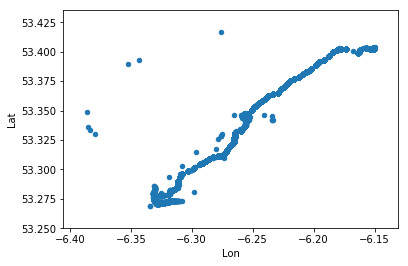

In [25]:
# Plotting stops in our data

locations = df[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

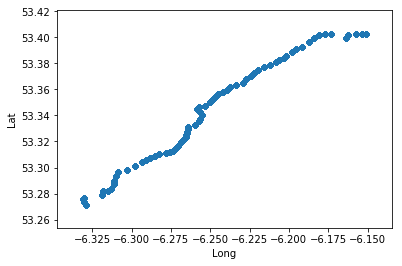

In [26]:
# Plotting stops in schedule

schedule_locations = schedule_line[["Long", "Lat"]]
schedule_locations.plot.scatter(x="Long", y="Lat")

In [28]:
# Plotting stops in schedule but not data (misc_stops)

set1 = set(df.StopID.unique())
set2 = set(schedule_line.StopID.unique())
misc_stops = set2.difference(set1)

misc_df = schedule_line[schedule_line.StopID.isin(misc_stops)]

misc_df.head()

if len(misc_df > 0):
    locations = misc_df[["Long", "Lat"]]
    locations.plot.scatter(x="Long", y="Lat")
else:
    print("No difference!")

No difference!


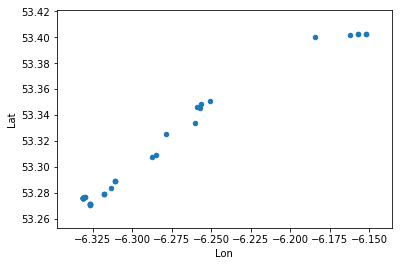

In [29]:
# Plotting stops in data but not schedule (misc_stops2)

set1 = set(df.StopID.unique())
set2 = set(schedule_line.StopID.unique())
misc_stops = set1.difference(set2)

misc_df = df[df.StopID.isin(misc_stops)]

misc_df.head()

if len(misc_df > 0):
    locations = misc_df[["Lon", "Lat"]]
    locations.plot.scatter(x="Lon", y="Lat")
else:
    print("No difference!")

### Removing irrelevant stops in our data

In [30]:
# df_0001["StopID"].value_counts()

In [31]:
# Removing stops that don't occur at least 100 times in our data

groups = df.groupby('StopID')
clean_0001 = groups.filter(lambda x: len(x) > 100)

In [32]:
clean_0001["StopID"].value_counts()

6282    6134
5190    3905
4415    3741
403     3715
4563    3527
1076    3007
348     2984
1277    2799
668     2705
1270    2661
1016    2635
1274    2635
746     2543
1014    2494
1273    2429
664     2410
1077    2387
1020    2384
844     2295
4594    2238
1220    2199
616     2184
1127    2176
615     2133
1085    2125
1081    2066
1145    2026
4595    1946
1125    1942
1130    1860
        ... 
3007    1477
6320    1477
1275    1473
4869    1472
665     1405
1143    1404
1017    1369
1221    1355
1219    1345
1144    1324
1141    1292
1082    1278
617     1266
6319    1199
1142    1199
7246    1183
4870    1096
619     1063
1080    1009
1019     985
1083     957
1018     917
1272     745
1124     664
666      588
1123     508
1078     504
1276     499
1122     414
6318     352
Name: StopID, dtype: int64

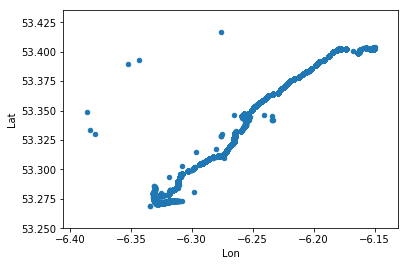

In [33]:
# Plotting stops in our data

locations = clean_0001[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

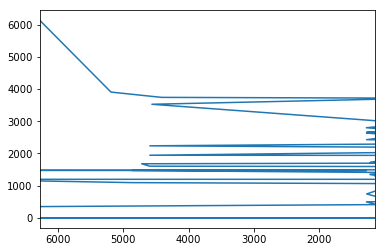

In [34]:
df["StopID"].value_counts().plot()

### Plotting common routes between data and schedule

In [35]:
set1 = set(df.StopID.unique())
set2 = set(schedule_line.StopID.unique())

common_stops = set2.intersection(set1)

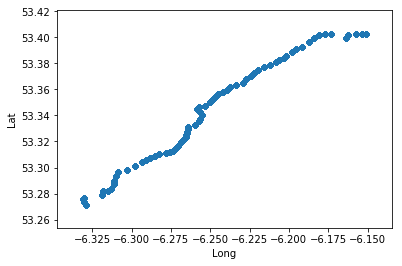

In [36]:
# Plotting stops in schedule and data (common_stops)

common_df = schedule_line[schedule_line.StopID.isin(common_stops)]

common_df.head()

locations = common_df[["Long", "Lat"]]
locations.plot.scatter(x="Long", y="Lat")